In [1]:
# Input
enrichment_dir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/enrichment/"
# Output
outdir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clones_change/filt_fisher__shuffle_False__padj_True__pthresh_0.01_minC_1__bothMinC__0/preproc"

# Params
pthresh = 0.01
clone_filt = "fisher"
min_cell = 1
min_cell_both = 1
use_p_adjust = True
shuffle = False

#p adjustments
to_calc_p_adjust = True
p_adj_col = "p_adj"

In [2]:
import pandas as pd
from os.path import join, exists
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
if not exists(outdir):
    os.mkdir(outdir)

In [4]:
#from glob import glob
#shuffle_stats_in = glob(join(enrichment_dir, "shuffle_stats", "*clone_shuffle.csv"))
#shuffle_stats_in

## Need to create name for each clone: {donor}_{cl} and d{donor}_cl{cl} is full id
## Need to create 'change' column for expand, regress, no_change
## Need to filter small clones if parameter is set

In [5]:
def get_change(x):
    if x["sig"] == False:
        return "no_change"
    if x[fold_col]>1:
        return "expand"
    else:
        return "regress"
    
clones = pd.read_csv(join(enrichment_dir, "enrichmentNorm.csv"))

fold_col = clones.columns.values[clones.columns.str.contains("fold enrichment norm")][0]
count_cols = clones.columns.values[clones.columns.str.contains("Cells in Cluster")]
clones["log2_fold"] = np.log2(clones[fold_col])

if clone_filt == "fisher":
    if to_calc_p_adjust:
        from statsmodels.stats.multitest import multipletests
        print("adjusting p value")
        _, clones["p_adj"], _, _ = multipletests(clones["Fisher p"].values, method="fdr_bh")
        
        clones["sig"] = clones["p_adj"] < pthresh
else: #make them all considered sig
    clones["sig"] = 1
    clones["p_adj"] = -1
    
clones["change"] = clones.apply(get_change, axis=1)   
clones["negLog10_p_adj"] = -np.log10(clones["p_adj"])
# Filter for minimum number of cells in clone 
print("Before min-cell filter")
print(clones.shape)
clones = clones.loc[clones[count_cols].sum(axis=1)>min_cell]
print("After min-cell filter")
print(clones.shape)

clones = clones.loc[(clones[count_cols]>min_cell_both).all(axis=1)]
print("After min-cell filter both")
print(clones.shape)
clones["name"] = clones["Donor"].astype(str) + "_" + clones["lineage"].astype(str)
clones["ID"] = "donor_"+clones["Donor"].astype(str) + "_clone_" + clones["lineage"].astype(str)
clones = clones.set_index("name")

if shuffle: 
    # if didnt pass shuffle_stats, then changed to no_change if not already
    shuffle_stats = pd.read_csv(join(enrichment_dir, "shuffle_stats", "shuffle_stats.csv"))
    sig_shuffle_stats = shuffle_stats[shuffle_stats["shuffle_sig_max"]==True].set_index("name")
    clones["shuffle_sig_max"] = False
    
    print("before shuffle stats groups")
    print(clones.groupby("change").size())
    clones.loc[clones.index.isin(sig_shuffle_stats.index), "shuffle_sig_max"] = True
    clones.loc[clones["shuffle_sig_max"]==False, "change"] = "no_change"
    #clones = clones[clones["shuffle_sig_max"]==True]
    print("after shuffle stats groups")
    print(clones.groupby("change").size())
out = clones[["p_adj", "sig", "change", "ID", "log2_fold", "negLog10_p_adj"]+list(count_cols)].sort_values("p_adj")


adjusting p value
Before min-cell filter
(97, 15)
After min-cell filter
(97, 15)
After min-cell filter both
(95, 15)


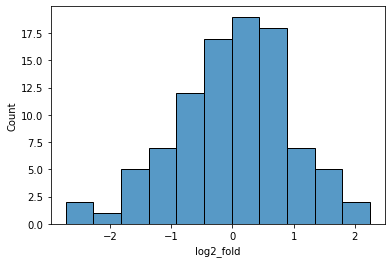

In [6]:
sns.histplot(clones["log2_fold"])
plt.savefig(join(outdir,"log2_enrich.png"))

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


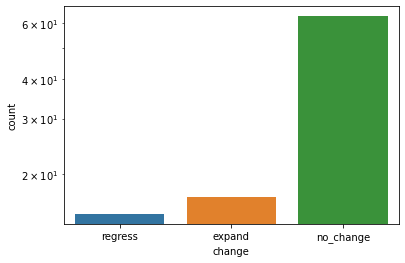

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(out["change"])
plt.yscale("log")
plt.savefig(join(outdir,"expand_hist.png"))

In [8]:
out.groupby("change").size().to_csv(join(outdir, "expand_counts.csv"))

In [9]:
out.to_csv(join(outdir, "clone_change.csv"))